<a href="https://colab.research.google.com/github/Jamnic98/blue-cheese-classifier/blob/main/blue_cheese_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
import os
import numpy as np
import shutil
import random

class_names = ['blueCheese', 'notBlueCheese']
root_dir = '/content/drive/MyDrive/'
val_ratio = 0.15
test_ratio = 0.05

all_cheese_image_dirs = {class_names[0]: [], class_names[1]: []}

for class_name in class_names:
  train_URI = root_dir +'data/train/' + class_name
  if not os.path.isdir(train_URI):
    os.makedirs(train_URI)
  
  test_URI = root_dir +'data/test/' + class_name
  if not os.path.isdir(test_URI):
    os.makedirs(test_URI)
  
  val_URI = root_dir +'data/val/' + class_name
  if not os.path.isdir(val_URI):
    os.makedirs(val_URI)

  cheeses = os.listdir(root_dir + class_name)

  for cheese_name in cheeses:
    cheese_dir = root_dir + class_name + '/' + cheese_name

    all_cheese_image_dirs[class_name].extend(
      [cheese_dir + '/'+ name for name in os.listdir(cheese_dir)]
      )  

In [4]:
for class_name in class_names:
  cheese_image_dirs = all_cheese_image_dirs[class_name]

  np.random.shuffle(cheese_image_dirs)

  train_FileNames, val_FileNames, test_FileNames = np.split(
    np.array(cheese_image_dirs),
    [int(len(cheese_image_dirs)* (1 - (val_ratio + test_ratio))), 
    int(len(cheese_image_dirs)* (1 - test_ratio))]
  )

  print('In folder :', class_name)
  print('Total images: ', len(cheese_image_dirs))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))
  print('\n')

  # # Copy-pasting images
  # for train_FileName in train_FileNames.tolist():
  #   shutil.copy(train_FileName, root_dir +'data/train/' + class_name)

  # for val_FileName in val_FileNames.tolist():
  #   shutil.copy(val_FileName, root_dir +'data/val/' + class_name)

  # for test_FileName in test_FileNames.tolist():
  #   shutil.copy(test_FileName, root_dir +'data/test/' + class_name)

In folder : blueCheese
Total images:  1896
Training:  1516
Validation:  285
Testing:  95


In folder : notBlueCheese
Total images:  1848
Training:  1478
Validation:  277
Testing:  93




In [5]:
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

augmented_images_dir=root_dir + 'augmented_images/'
if not os.path.isdir(augmented_images_dir):
  os.mkdir(augmented_images_dir)

# augment the data that we have
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=15,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# prepare training data
augmented_train_images_dir = augmented_images_dir + 'train'
if not os.path.isdir(augmented_train_images_dir):
  os.mkdir(augmented_train_images_dir)
training_data = train_datagen.flow_from_directory('data/train',
                                                  #save_to_dir=augmented_train_images_dir,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode='categorical'
                                                  )

# prepare test data
augmented_test_images_dir = augmented_images_dir + 'test'
if not os.path.isdir(augmented_test_images_dir):
  os.mkdir(augmented_test_images_dir)
test_data = test_datagen.flow_from_directory('data/test',
                                              #save_to_dir=augmented_test_images_dir,
                                              target_size = (64, 64),
                                              batch_size = 32,
                                              class_mode = 'categorical'
                                              )

# prepare validation data
augmented_val_images_dir = augmented_images_dir + 'val'
if not os.path.isdir(augmented_val_images_dir):
  os.mkdir(augmented_val_images_dir)
validation_data = test_datagen.flow_from_directory('data/val',
                                                    #save_to_dir=augmented_val_images_dir,
                                                    target_size = (64, 64),
                                                    batch_size = 32,
                                                    class_mode = 'categorical'
                                                    )

Found 2994 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Found 562 images belonging to 2 classes.


In [6]:
### Build the model
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# make 32 feature detectors with a size of 3x3
# choose the input-image's format to be 64x64 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation="relu"))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="softmax", units=2))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### **Change code below this message**

In [7]:
history = classifier.fit(training_data,
               #steps_per_epoch = (100),
               epochs=15,
               validation_data=validation_data,
               validation_steps=10)

Epoch 1/15
 1/94 [..............................] - ETA: 35:49 - loss: 0.6846 - accuracy: 0.5625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/94 [======>.......................] - ETA: 8:27 - loss: 0.9604 - accuracy: 0.5211

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19 bytes but only got 18. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag)


94/94 [==============================] - 775s 8s/step - loss: 0.7676 - accuracy: 0.5745 - val_loss: 0.5746 - val_accuracy: 0.7031
Epoch 2/15
94/94 [==============================] - 86s 913ms/step - loss: 0.6040 - accuracy: 0.6673 - val_loss: 0.5696 - val_accuracy: 0.6656
Epoch 3/15
94/94 [==============================] - 70s 752ms/step - loss: 0.5702 - accuracy: 0.6958 - val_loss: 0.6993 - val_accuracy: 0.6125
Epoch 4/15
94/94 [==============================] - 61s 647ms/step - loss: 0.5686 - accuracy: 0.6936 - val_loss: 0.6276 - val_accuracy: 0.6719
Epoch 5/15
94/94 [==============================] - 59s 628ms/step - loss: 0.5358 - accuracy: 0.7131 - val_loss: 0.4767 - val_accuracy: 0.7469
Epoch 6/15
94/94 [==============================] - 58s 616ms/step - loss: 0.5015 - accuracy: 0.7446 - val_loss: 0.4960 - val_accuracy: 0.7531
Epoch 7/15
94/94 [==============================] - 57s 609ms/step - loss: 0.4851 - accuracy: 0.7650 - val_loss: 0.5256 - val_accuracy: 0.7719
Epoch 8/15
9

In [8]:
generator= train_datagen.flow_from_directory("data/train", batch_size=32)
label_map = (generator.class_indices)
label_map

Found 2994 images belonging to 2 classes.


{'blueCheese': 0, 'notBlueCheese': 1}

In [9]:
## make predictions
import numpy as np
from keras.preprocessing import image
# we have to resize our image if we haven't already
test_image = image.load_img('data/test/notBlueCheese/comte103.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print('Predicted class: ', int(result[0][0]))
print(result)

predictions = classifier.predict(test_data)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())


import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
confusion_matrix

Predicted class:  0
[[0. 1.]]


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


               precision    recall  f1-score   support

   blueCheese       0.50      0.52      0.51        95
notBlueCheese       0.49      0.47      0.48        93

     accuracy                           0.49       188
    macro avg       0.49      0.49      0.49       188
 weighted avg       0.49      0.49      0.49       188



array([[49, 46],
       [49, 44]])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 2s - loss: 0.3410 - accuracy: 0.8457
Accuracy:  0.8457446694374084


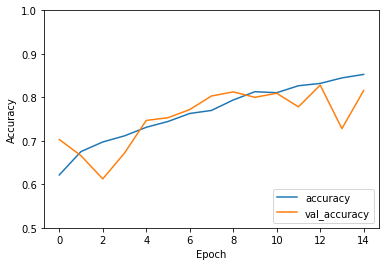

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
print('Accuracy: ', test_acc)

In [12]:
# model_dir = root_dir + 'my_model'

# if not os.path.isdir(model_dir):
#   os.mkdir(model_dir)

# classifier.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model/assets
